# 0. Imports and Useful Functions from Other Notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('female_test.pkl')
dft = pd.read_pickle('female_train.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [2]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

# 1. Fitting All Variables

In [3]:
# dft.iloc[0].dataframe.head()

In [4]:
# df_train = {}
# for idx in range(len(df)):
#     name = dft.iloc[idx].modality
#     data = dft.iloc[idx].dataframe.mean_output_age.to_list()
#     df_train[name] = data
    
# df_train = pd.DataFrame.from_dict(df_train)
# df_train['target_age'] = dft.iloc[0].dataframe.target_age.to_list()

In [5]:
# df_train.head()

In [6]:
# df.iloc[0].dataframe.head()

In [7]:
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

In [8]:
df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [9]:
df_testA

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
2820,66.709417,67.442993,61.093726,62.254519,69.164342,63.855006,67.249040,58.140988,62.120589,64.160736,...,62.182788,61.906055,63.804283,61.755967,58.793064,62.017001,62.214266,65.457215,64.070314,66.449886
1708,60.944236,61.842161,58.154415,63.287874,59.937619,60.383603,64.117655,57.543353,54.386728,55.125870,...,59.943876,59.250686,62.674294,59.842834,60.130049,60.041532,60.133045,58.552697,60.884393,56.750799
3530,69.986284,70.044437,67.995620,68.787147,66.860631,63.243362,65.436874,67.694233,64.469723,67.990499,...,69.095557,68.243078,70.294473,71.528098,68.952060,68.205580,68.265059,67.692567,71.046120,74.181393
3480,50.189046,49.536327,55.061271,52.386892,51.970549,55.862569,54.179867,54.311277,60.954406,58.720743,...,52.460709,51.984690,52.651951,51.896004,51.796198,53.048449,51.241098,53.523593,52.749642,48.054909
670,71.524370,74.981445,69.319275,72.855853,68.487738,74.630128,70.888287,67.358183,62.182683,68.813820,...,69.198738,68.378360,69.722930,69.319782,69.967300,67.481915,68.142391,68.747928,68.246657,71.225457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,72.453860,72.777170,71.681043,71.683783,68.714974,69.766270,65.685925,68.641963,70.857667,65.476047,...,72.687613,70.522855,69.902572,70.420770,72.571650,73.341687,71.503297,68.441695,70.658153,68.973630
2763,53.351702,52.271532,55.079981,52.161547,53.909411,59.786398,53.030368,53.165982,57.423242,53.322554,...,54.309854,54.178987,56.800108,56.448681,54.016900,55.505735,58.626230,55.986900,56.154284,54.153767
905,69.209973,69.500987,68.698557,66.651488,68.785348,63.463698,66.667837,69.449155,71.894450,69.530817,...,63.842171,67.179692,66.388185,68.495769,66.448707,68.125218,69.551362,71.481080,67.318527,69.441940
3980,52.488741,52.919326,49.097110,55.224999,54.686887,56.643762,55.647718,51.043516,51.264160,49.018145,...,52.269901,53.618629,52.570537,50.347670,49.235783,51.978335,49.282260,49.503878,51.560833,55.862215


In [10]:
subjects_testA

[22054514,
 25268986,
 22875938,
 25442183,
 23642270,
 24683977,
 24329308,
 23894914,
 25314741,
 25319930,
 21608871,
 24956327,
 23762821,
 21240825,
 22051909,
 22013525,
 22275306,
 23468663,
 24715105,
 23240097,
 23308658,
 21685684,
 23821201,
 24002825,
 24642194,
 21217138,
 25294747,
 24641107,
 22361310,
 23967623,
 23707435,
 24589434,
 24485260,
 25404228,
 23485015,
 22601778,
 21884709,
 25668571,
 22145312,
 22646410,
 25527675,
 24162777,
 22991845,
 21050588,
 23784162,
 23355424,
 25909123,
 24015352,
 22808678,
 24863953,
 22798091,
 23563217,
 21176735,
 24853985,
 23438861,
 25750897,
 22191520,
 21834608,
 23905218,
 24185328,
 23824009,
 23474872,
 21129715,
 23033552,
 25595426,
 21900903,
 21595552,
 24077718,
 24287968,
 24793251,
 25074821,
 23244519,
 25513599,
 22873657,
 22727139,
 21801687,
 22112060,
 23916500,
 23307783,
 24312112,
 23868588,
 22517009,
 21730922,
 23945712,
 24459340,
 24087504,
 21834289,
 21080185,
 24715543,
 21855291,
 22586552,

In [11]:
df.iloc[0].dataframe.iloc[[2820]]

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
2820,22054514,66.449886,67.997116,1.54723,2.393921,66.096794,-0.353092,0.124674,66.03434,-0.415546,0.172678,66.709417,0.259531,67.180142,0.730256


In [12]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T1_linear,Unnamed: 0 target_age output_age_1 ag...
2,jacobian,Unnamed: 0 target_age output_age_1 ag...
3,vbm,Unnamed: 0 target_age output_age_1 ag...
4,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...
5,T2_lesions,Unnamed: 0 target_age output_age_1 ag...
6,swi,Unnamed: 0 target_age output_age_1 ag...
7,rsfmri_0,Unnamed: 0 target_age output_age_1 ag...
8,rsfmri_1,Unnamed: 0 target_age output_age_1 ag...
9,rsfmri_2,Unnamed: 0 target_age output_age_1 ag...


In [13]:
modalitiesA, modalitiesB = [], []
dataframesA, dataframesB = [], []
for idx in range(len(df)):
    modalitiesA.append(df.iloc[idx].modality)
    modalitiesB.append(df.iloc[idx].modality)
    dataframe = df.iloc[idx].dataframe
    dfA, dfB = train_test_split(dataframe, test_size=0.5, random_state=1)
    dataframesA.append(dfA)
    dataframesB.append(dfB)
dfA = pd.DataFrame.from_dict({
    'modality': modalitiesA,
    'dataframe': dataframesA
})
dfB = pd.DataFrame.from_dict({
    'modality': modalitiesB,
    'dataframe': dataframesB
})
dfA.to_pickle('female_testA.pkl', protocol = 4)
dfB.to_pickle('female_testB.pkl', protocol = 4)

In [14]:
subjects_testA = np.array(subjects_testA).astype(int)
subjects_testB = np.array(subjects_testB).astype(int)
np.savetxt('female_testA.txt', subjects_testA, fmt='%s')
np.savetxt('female_testB.txt', subjects_testB, fmt='%s')

In [15]:
dfA = pd.read_pickle('female_testA.pkl')
dfA.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
2820,22054514,66.449886,67.997116,1.547230,2.393921,66.096794,-0.353092,0.124674,66.034340,-0.415546,0.172678,66.709417,0.259531,67.180142,0.730256
1708,25268986,56.750799,60.836470,4.085672,16.692720,61.384384,4.633585,21.470111,60.611855,3.861055,14.907749,60.944236,4.193437,60.420727,3.669927
3530,22875938,74.181393,69.916176,-4.265217,18.192075,68.213715,-5.967678,35.613182,71.828960,-2.352436,5.533956,69.986284,-4.195109,71.022122,-3.159271
3480,25442183,48.054909,52.335880,4.280972,18.326718,51.335102,3.280193,10.759669,46.896156,-1.158752,1.342707,50.189046,2.134137,47.810748,-0.244160
670,23642270,71.225457,69.281130,-1.944329,3.780414,72.452950,1.227493,1.506739,72.839030,1.613571,2.603611,71.524370,0.298913,72.825459,1.600002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,22375314,68.973630,71.586740,2.613108,6.828336,74.477500,5.503871,30.292594,71.297340,2.323710,5.399629,72.453860,3.480230,73.915244,4.941614
2763,21976334,54.153767,52.845080,-1.308686,1.712659,55.529324,1.375556,1.892156,51.680702,-2.473065,6.116050,53.351702,-0.802065,51.518821,-2.634947
905,23847459,69.441940,71.690630,2.248688,5.056598,69.585980,0.144043,0.020748,66.353310,-3.088630,9.539637,69.209973,-0.231967,70.111932,0.669993
3980,23077712,55.862215,52.760570,-3.101644,9.620196,51.031390,-4.830823,23.336855,53.674263,-2.187952,4.787132,52.488741,-3.373474,50.507038,-5.355177


In [16]:
def LinearRegression_wrap(df_train, df_test, modalities = None, number_of_modalities=None, 
                          show_plots=False, verbose=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    reg = LinearRegression().fit(Xtrain.T, Ytrain)
    coefficients = reg.coef_
    intercept = reg.intercept_

    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
#     print(mean_squared_error(Yhat, Ytest, squared=False))
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon, Yhat, Age_Deltas)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

In [17]:
# def ElasticNet_wrap(df_train, df_test, modalities = None, number_of_modalities=None, 
#                           show_plots=False, verbose=False, deconfound=False):
    
#     Xtrain = []
#     Ytrain = []
    
#     if modalities == None:
#         if number_of_modalities == None:
#             for col in df_train.columns[:-1]:
#                 Xtrain.append(np.array(df_train[col].to_list()))
#         else:
#             for col in df_train.columns[:number_of_modalities]:
#                 print(col)
#                 Xtrain.append(np.array(df_train[col].to_list()))
#     else:
#         for modality in modalities:
#             Xtrain.append(np.array(df_train[modality].to_list()))

#     Xtrain = np.array(Xtrain)
#     Ytrain = np.array(df_train['target_age'].to_list())

#     model = ElasticNet(alpha=0.1, l1_ratio=0.5)       
#     reg = model.fit(Xtrain.T, Ytrain)
# #     reg = LinearRegression().fit(Xtrain.T, Ytrain)
#     coefficients = reg.coef_
#     intercept = reg.intercept_

#     Xtest = []
    
#     if modalities == None:
#         if number_of_modalities == None:
#             for col in df_train.columns[:-1]:
#                 Xtest.append(np.array(df_test[col].to_list()))
#         else:
#             for col in df_train.columns[:number_of_modalities]:
#                 Xtest.append(np.array(df_test[col].to_list()))
#     else:
#         for modality in modalities:
#             Xtest.append(np.array(df_test[modality].to_list()))
        
#     Xtest = np.array(Xtest)
#     Ytest = np.array(df_test['target_age'].to_list())

#     Yhat = reg.predict(Xtest.T)
#     Age_Deltas = Yhat - Ytest
    
#     if deconfound == True:
#         Yhat_decon = age_deconfounding(Yhat, Ytest)
#         Age_Deltas_decon = Yhat_decon - Ytest
#     else:
#         Yhat_decon = None
#         Age_Deltas_decon = None
    
#     mae = np.abs(Age_Deltas).mean()
#     pr = pearsonr(Ytest, Yhat)[0]
    
#     if deconfound == True:
#         mae_decon = np.abs(Age_Deltas_decon).mean()
#         pr_decon = pearsonr(Ytest, Yhat_decon)[0]
#     else:
#         mae_decon = None
#         pr_decon = None
    
#     if verbose == True:
#         print('MAE=', mae)
#         print('PR=', pr)
#         if deconfound == True:
#             print('MAE Decon=', mae_decon)
#             print('PR Decon=', pr_decon)
    
#     if show_plots == True:
#         scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
#                                ylabel='Predicted Age', title=None, set_scale=True)

#         scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Delta', title=None, set_scale=False, 
#                                equality_line=False)

#         kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age', title=None)
        
#         if deconfound == True:
#             scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
#                                    ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

#             scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
#                                    ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                                    equality_line=False)

#             kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
#     if deconfound == True:
#         return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
#                 Age_Deltas_decon)
#     else:
#         return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

Modality      : MAE             |  MAE (Decon)       

T1_nonlinear  :  2.227 ± 0.024  |   2.429 ± 0.025 

T1_linear     :  2.332 ± 0.025  |   2.550 ± 0.027 

T2_nonlinear  :  2.204 ± 0.024  |   2.372 ± 0.026 


In [18]:
# Xtrain = []
# Ytrain = []
# for col in df_train.columns[:-1]:
#     Xtrain.append(np.array(df_train[col].to_list()))
# Xtrain = np.array(Xtrain)
# Ytrain = np.array(df_train['target_age'].to_list())

# reg = LinearRegression().fit(Xtrain.T, Ytrain)
# coefficients = reg.coef_
# intercept = reg.intercept_

# Xtest = []
# for col in df_train.columns[:-1]:
#     Xtest.append(np.array(df_test[col].to_list()))
# Xtest = np.array(Xtest)
# Ytest = np.array(df_test['target_age'].to_list())
    
# Yhat = reg.predict(Xtest.T)

# # Yhat_decon = age_deconfounding(Yhat, Ytest)
# # Age_Deltas_decon = Yhat_decon - Ytest
# Yhat = age_deconfounding(Yhat, Ytest)

# Age_Deltas = Yhat - Ytest
# print('MAE=', np.abs(Age_Deltas).mean())
# print('PR=', pearsonr(Ytest, Yhat)[0])
# print(reg.intercept_)

# scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

# scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                        equality_line=False)

# kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

MAE= 1.9913453007284048
PR= 0.9393570756476785
MAE Decon= 2.121598228970744
PR Decon= 0.9393570756476785


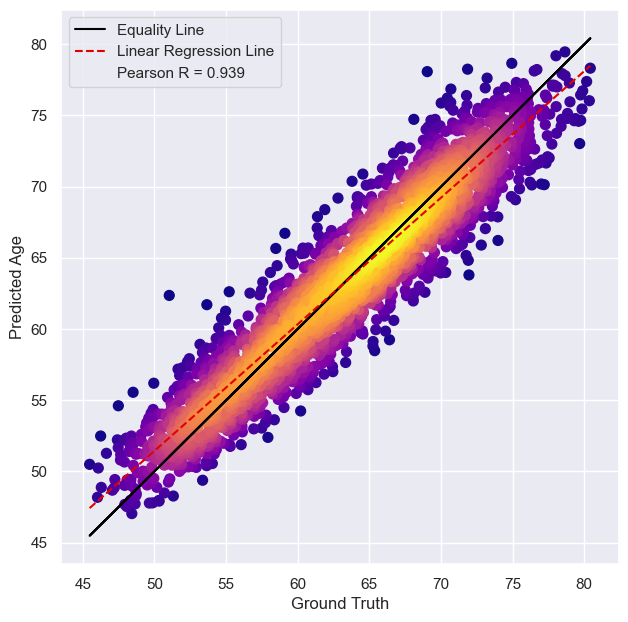

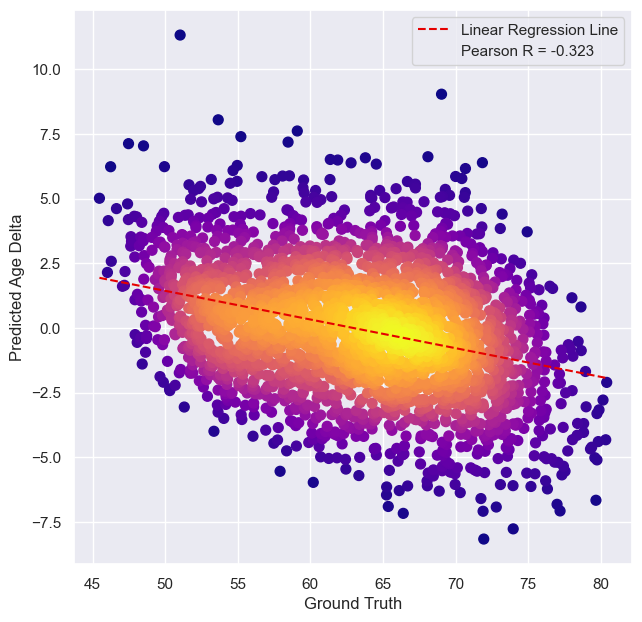

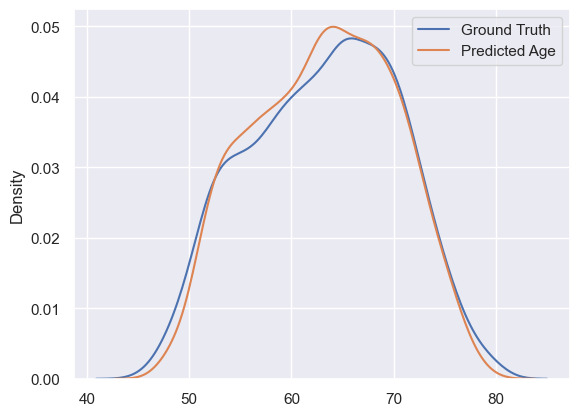

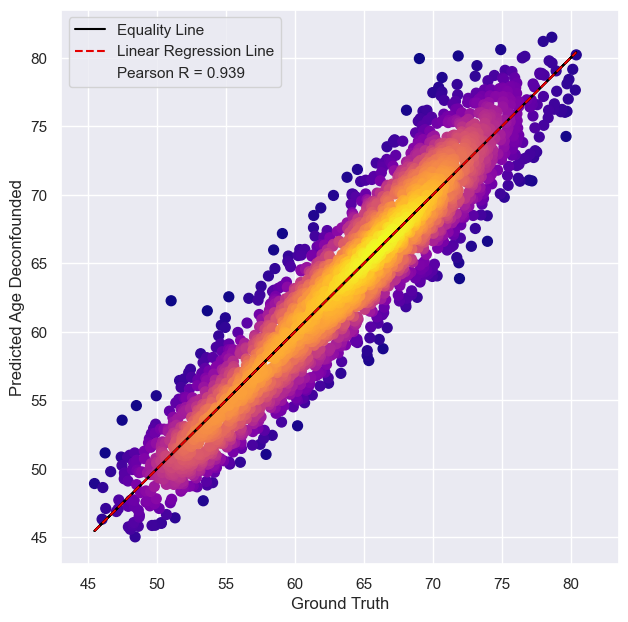

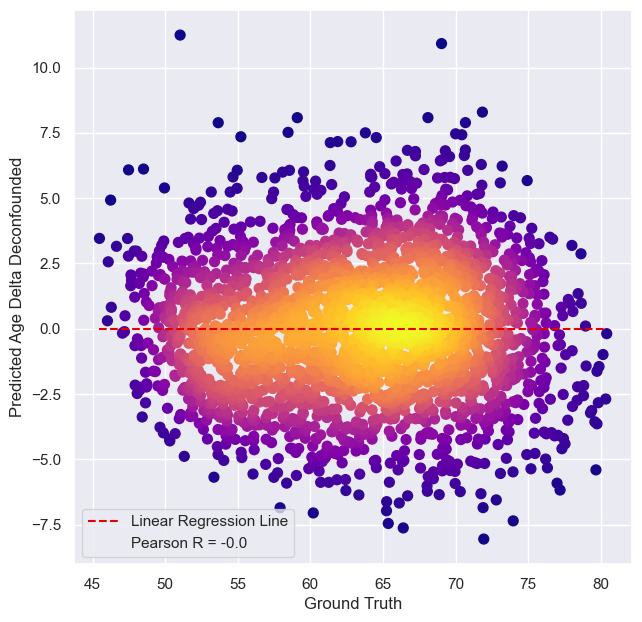

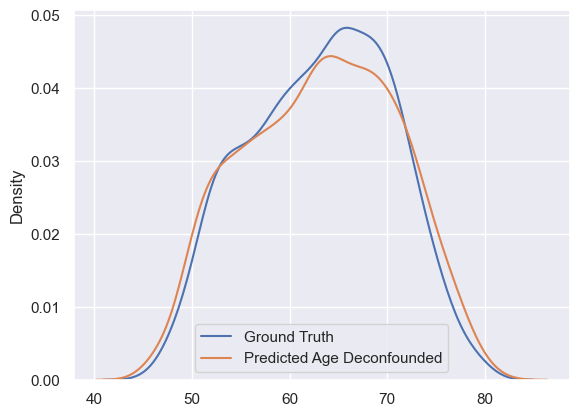

In [19]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, Yhat, Age_Deltas = LinearRegression_wrap(
    df_train=df_testA, df_test=df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

In [86]:
# YhatT = reg.predict(Xtrain.T)
# Age_Deltas_T = YhatT - Ytrain

# print('MAE Train=', np.abs(Age_Deltas_T).mean())
# print('PR Train=', pearsonr(Ytrain, YhatT)[0])

# scatter_plot_heatmap(x=Ytrain, y=YhatT, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

# scatter_plot_heatmap(x=Ytrain, y=Age_Deltas_T, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                        equality_line=False)

# kde_plot(x=Ytrain, y=YhatT, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

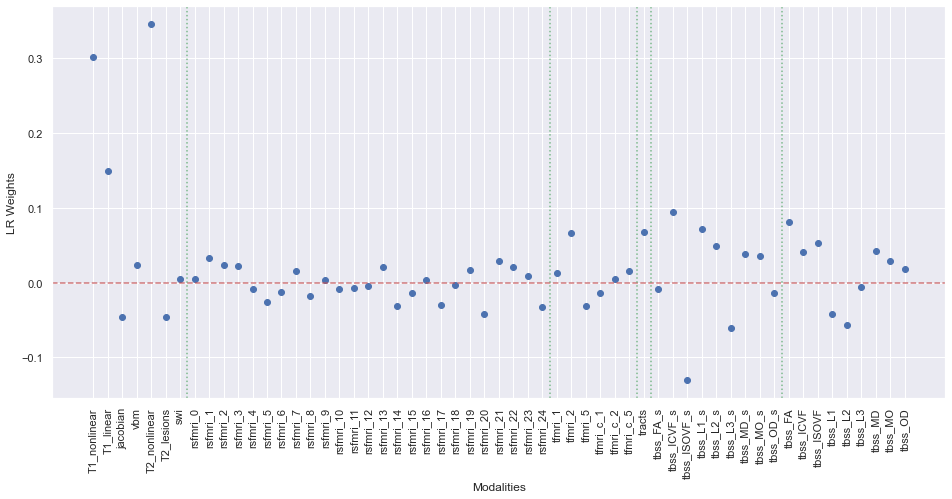

In [87]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), dft.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

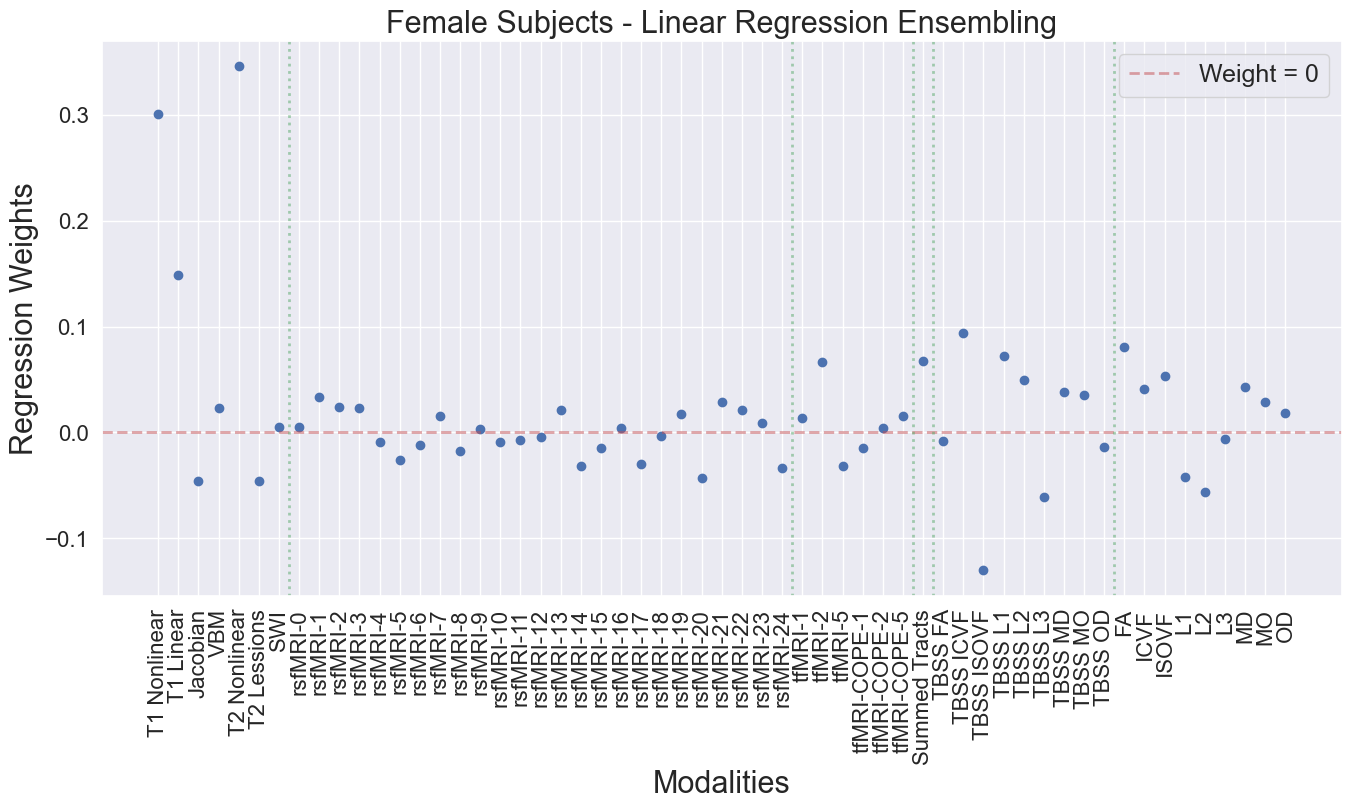

In [21]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weight = 0');
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);

plt.legend(loc=1, fontsize=legend_font)

plt.title('Female Subjects - Linear Regression Ensembling', fontsize=title_font_size)

fig.savefig('Female_liner_regression_weights.png', bbox_inches='tight')


In [38]:
Age_Deltas

array([ 2.23801163, -3.22019728, -2.00329482, ...,  1.79766083,
       -4.27062383, -2.53161405])

In [43]:
df_output = pd.DataFrame.from_dict({
    'modality': 'LinearRegressionFull',
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon,
                'mean_age_delta': Age_Deltas,
                'target_age': df_testB.target_age.values,
                'mean_output_age': Yhat
                })]
})

output_name = 'female_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon mean_age_de...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon mean_age_de...


In [44]:
df_ensambles.iloc[1].dataframe

,Unnamed: 0,age_delta_decon,mean_age_delta,target_age,mean_output_age
0,25731272,2.056300,2.238012,59.311073,61.549085
1,23327192,-3.058594,-3.220197,67.523907,64.303710
2,21569423,-1.102638,-2.003295,72.236872,70.233577
3,25730176,-1.692224,-2.197839,69.261758,67.063919
4,23094690,1.978307,3.368005,48.488699,51.856703
...,...,...,...,...,...
2506,23930771,-0.728086,-1.486324,70.577186,69.090862
2507,24847070,6.474252,5.081360,69.101712,74.183072
2508,23169754,1.350076,1.797661,57.618169,59.415830
2509,25240989,-3.453365,-4.270624,73.835046,69.564422


In [18]:
# df_output = pd.DataFrame.from_dict({
#     'modality': 'LinearRegressionFull',
#     'dataframe': [pd.DataFrame.from_dict({
#                 'Unnamed: 0': subjects_testB,
#                 'age_delta_decon': Age_Deltas_decon
#                 })]
# })

# output_name = 'female_ensembles_testset.pkl'

# if os.path.exists(output_name):
#     df_ensambles = pd.read_pickle(output_name)
#     if df_output.iloc[0].modality in df_ensambles.modality.to_list():
#         pass
#     else:
#         df_ensambles = pd.concat([df_ensambles, df_output])
#         df_ensambles.to_pickle(output_name, protocol = 4)
# else:
#     df_output.to_pickle(output_name, protocol = 4)
    
# df_ensambles = pd.read_pickle(output_name)
# df_ensambles

NameError: name 'ensambled_deltas_deconfounded' is not defined

# 1.0.1. ElasticNet with TRAIN & test with TEST_B

In [22]:
# reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
#     df_train, df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

In [23]:
# df_testA

In [24]:
# df_testA_deltas = df_testA.sub(df_testA['target_age'], axis=0)
# df_testA_maes = abs(df_testA_deltas).mean()[:-1].to_numpy()
# min(df_testA_maes)

In [25]:
# maes_deconf = []
# Ytest = df_testA.target_age.to_numpy()
# for column in df_testA.columns[:-1]:
#     Yhat = df_testA[column]
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     maes_deconf.append(mae_decon)
# print(min(maes_deconf))

In [26]:
# plt.figure(figsize=(16, 7.2))
# # plt.plot(coefficients)
# plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
# plt.xticks(np.arange(0, Xtrain.shape[0]), dft.modality.to_list(), rotation=90);
# plt.xlabel("Modalities")
# plt.ylabel("LR Weights")
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
# plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

In [27]:
# df_testB_deltas = df_testB.sub(df_testB['target_age'], axis=0)
# df_testB_maes = abs(df_testB_deltas).mean()[:-1].to_numpy()
# min(df_testB_maes)

In [28]:
# maes_deconf = []
# Ytest = df_testB.target_age.to_numpy()
# for column in df_testB.columns[:-1]:
#     Yhat = df_testB[column]
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     maes_deconf.append(mae_decon)
# print(min(maes_deconf))

# 1.0.2 ElasticNet train TEST_A & test with TEST_B 

In [29]:
# reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
#     df_testA, df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

In [30]:
# plt.figure(figsize=(16, 7.2))
# # plt.plot(coefficients)
# plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
# plt.xticks(np.arange(0, Xtrain.shape[0]), dft.modality.to_list(), rotation=90);
# plt.xlabel("Modalities")
# plt.ylabel("LR Weights")
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
# plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

# Continue from before...

In [32]:
# os.remove(output_name)

## 1.1 Fitting a subclass of modalities, based on the observed performance from above

In [31]:
coef_df = pd.DataFrame.from_dict({
    'modalities' : dft.modality.to_list(),
    'coefficients' : coefficients
})
coef_df['abs_coef'] = np.abs(coef_df.coefficients)
coef_df = coef_df.sort_values('abs_coef', ascending=False)
coef_df

,modalities,coefficients,abs_coef
4,T2_nonlinear,0.345849,0.345849
0,T1_nonlinear,0.301226,0.301226
1,T1_linear,0.148764,0.148764
41,tbss_ISOVF_s,-0.130161,0.130161
40,tbss_ICVF_s,0.094423,0.094423
48,tbss_FA,0.080608,0.080608
42,tbss_L1_s,0.072246,0.072246
38,tracts,0.067801,0.067801
33,tfmri_2,0.066461,0.066461
44,tbss_L3_s,-0.060527,0.060527


2.492137705350404
MAE= 1.9826636471730248
PR= 0.9397484656929654
MAE Decon= 2.114377571275866
PR Decon= 0.9397484656929652


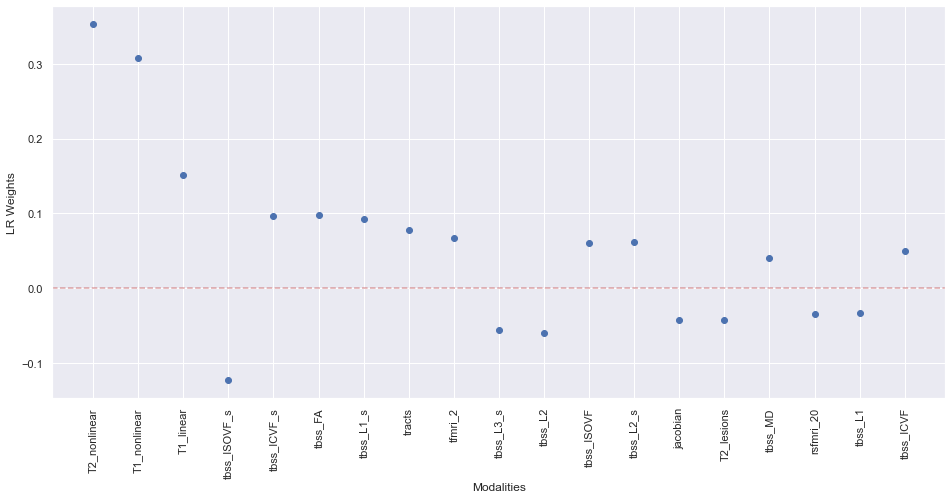

In [32]:
cutoff_weight = 0.04

misc_mod = coef_df[coef_df.abs_coef >= cutoff_weight].modalities.to_list()
x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=misc_mod, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), misc_mod, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

## 1.2 Fitting Variables Progressivelly, in order of Beta-Weight-Coef value

In [44]:
ordered_modalities0 = coef_df.modalities.to_list()

maes_list0 = []
number_of_modalities0 = []

for i in range(2, len(coef_df)+1):
    modalities0 = ordered_modalities0[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities0, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
    mae = x[3]    
    maes_list0.append(mae)
    number_of_modalities0.append(i)

In [45]:
ordered_modalities0x = coef_df.modalities.to_list()

maes_list0x = []
number_of_modalities0x = []

for i in range(2, len(coef_df)+1):
    modalities0x = ordered_modalities0x[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities0x, 
                              number_of_modalities=None, show_plots=False, verbose=False)
    maex = x[3]    
    maes_list0x.append(maex)
    number_of_modalities0x.append(i)

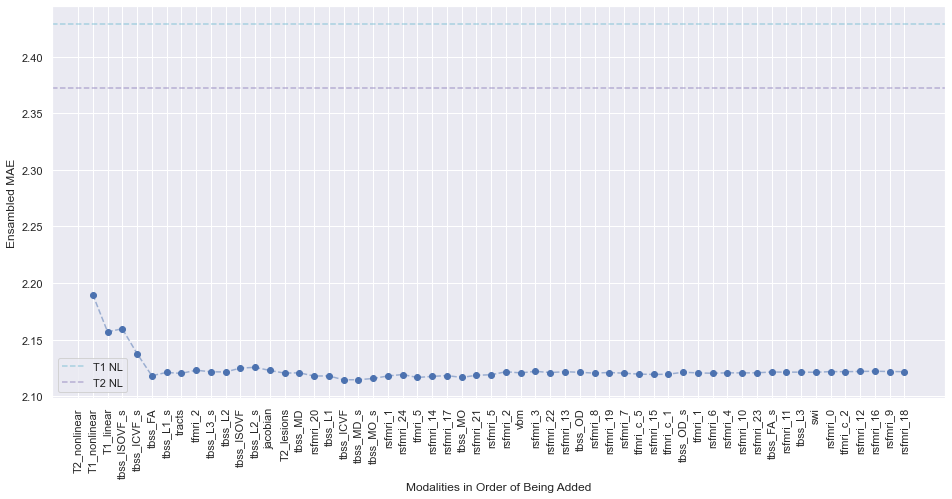

In [46]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0)
plt.plot(number_of_modalities0, maes_list0, 'b--', alpha=0.5)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities0, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.429, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.372, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

In [47]:
ordered_modalities0[np.argmin(maes_list0)]

'tbss_L1'

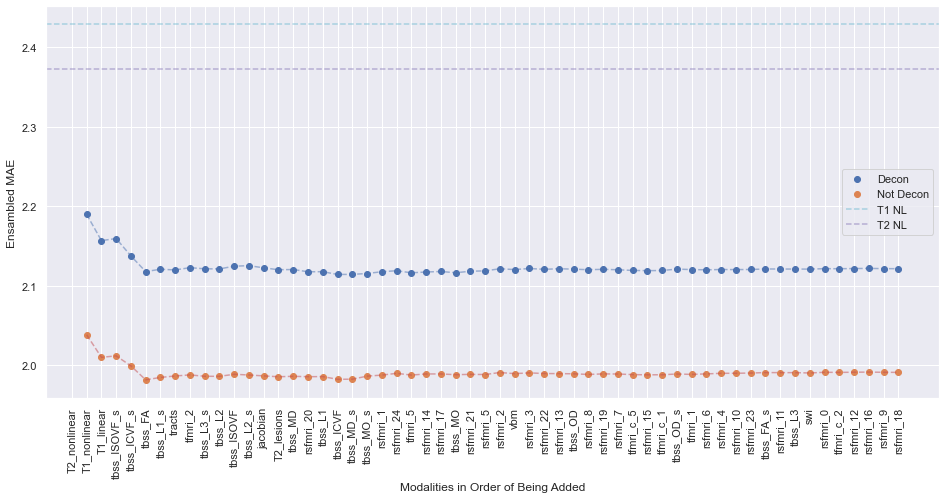

In [48]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0, label='Decon')
plt.plot(number_of_modalities0, maes_list0, 'b--', alpha=0.5)
plt.scatter(number_of_modalities0x, maes_list0x, label='Not Decon')
plt.plot(number_of_modalities0x, maes_list0x, 'r--', alpha=0.5)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities0, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.429, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.372, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 2. Fitting Variables Progressivelly, in order of best Test MAEs

In [49]:
modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

,modality,mae_decon
4,T2_nonlinear,2.372138
0,T1_nonlinear,2.429401
1,T1_linear,2.549765
3,vbm,2.925686
49,tbss_ICVF,2.951742


In [50]:
ordered_modalities = mae_df.modality.to_list()
maes_list = []
prs_list = []
number_of_modalities = []

for i in range(2, len(mae_df)+1):
    modalities = ordered_modalities[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
    mae = x[3]
    pr = x[4]
    maes_list.append(mae)
    prs_list.append(pr)
    number_of_modalities.append(i)

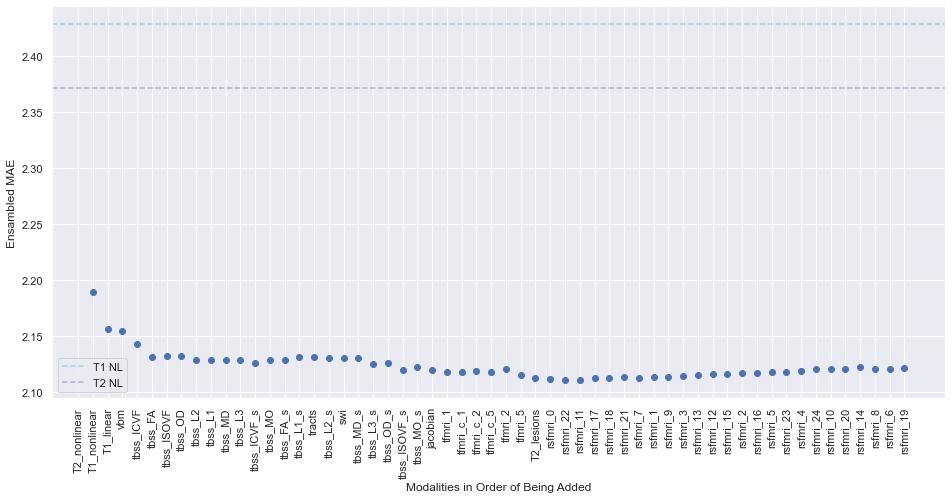

In [51]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities, maes_list)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.429, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.372, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 3. Fitting Variables Progressivelly, in order of best Train MAEs

In [52]:
modality_decon_maest = []

for idx in range(len(dft)):
    modality_decon_maet = np.abs(dft.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maest.append(modality_decon_maet)
    
mae_dft = pd.DataFrame.from_dict({
    'modality': dft.modality.to_list(),
    'mae_decon': modality_decon_maest
})

mae_dft = mae_dft.sort_values('mae_decon')
mae_dft.head()

,modality,mae_decon
0,T1_nonlinear,0.637949
1,T1_linear,0.652155
55,tbss_MO,0.685403
32,tfmri_1,0.917476
6,swi,1.199708


In [53]:
ordered_modalitiest = mae_dft.modality.to_list()
maes_listt = []
number_of_modalitiest = []

for i in range(2, len(mae_df)+1):
    modalities = ordered_modalitiest[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
    mae = x[3]
    maes_listt.append(mae)
    number_of_modalitiest.append(i)

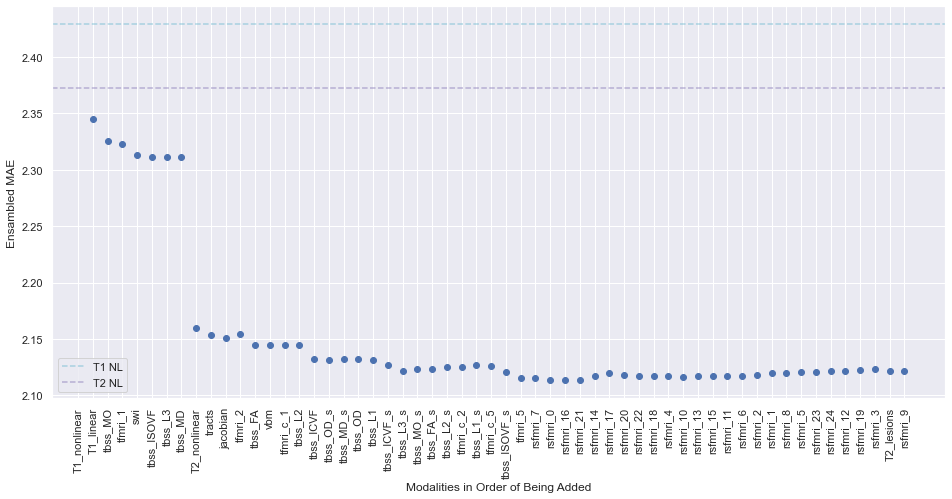

In [54]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalitiest, maes_listt)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalitiest, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.429, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.372, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 4. Fit Model to subgroups of variables (Notebook 4)

In [55]:
custom_modalities = ['T1_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_FA']
custom_modalities_2 = ['T2_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_ICVF']
custom_modalities_3 = ['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']

MAE= 2.1425309630794915
PR= 0.929023220446822
MAE Decon= 2.3256595229717676
PR Decon= 0.929023220446822


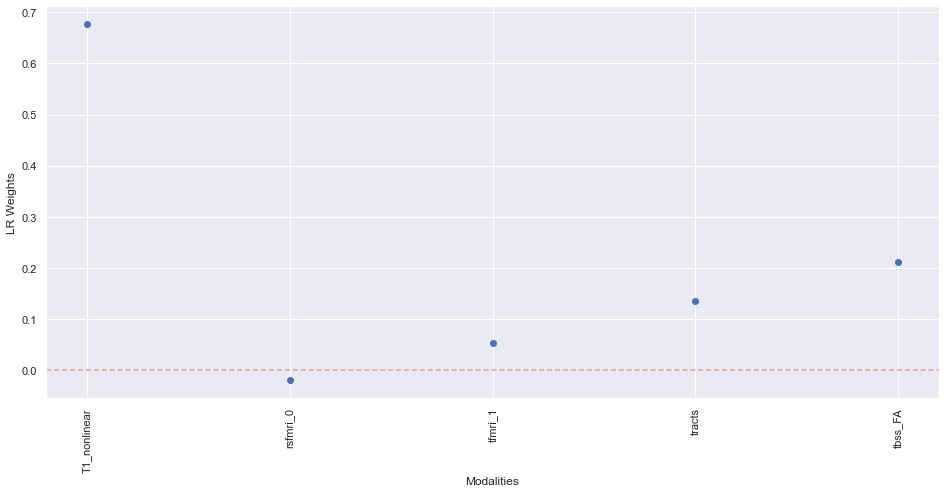

In [56]:
x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=custom_modalities, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

MAE= 2.0960784995449075
PR= 0.9319777830311389
MAE Decon= 2.2549649232246667
PR Decon= 0.9319777830311393


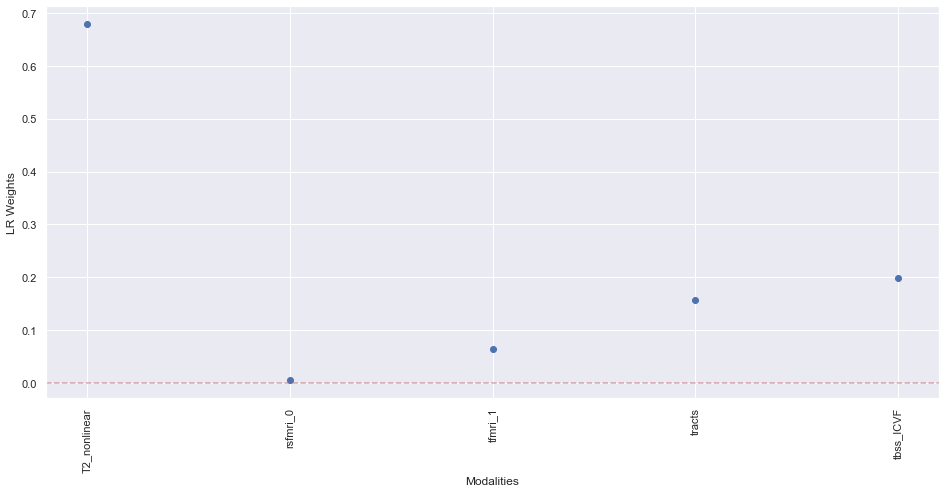

In [57]:
x = LinearRegression_wrap(df_train, df_test, modalities=custom_modalities_2, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_2, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

MAE= 2.031014873623919
PR= 0.9362839588216327
MAE Decon= 2.1746972521943344
PR Decon= 0.9362839588216325


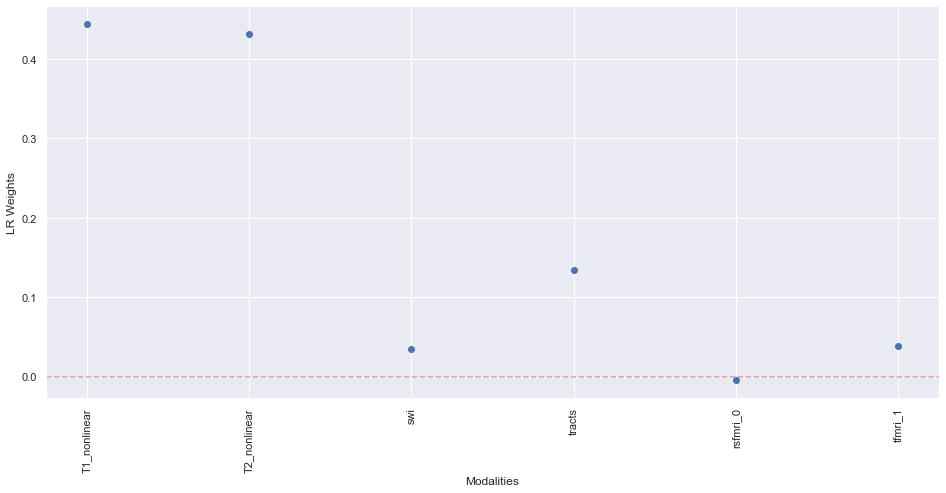

In [58]:
x = LinearRegression_wrap(df_train, df_test, modalities=custom_modalities_3, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_3, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

In [59]:
df_test.head()

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
4782,63.245763,60.347539,59.175664,60.535280,60.572191,64.271554,60.995139,61.454180,65.820454,54.018154,...,59.640923,59.256958,60.798890,59.529524,60.710006,61.519483,58.473717,63.440821,60.856472,59.311073
1499,65.723238,64.545638,64.115105,61.995279,61.336338,58.351572,61.548383,63.829018,65.781898,63.909287,...,60.730879,62.307837,59.981651,61.838904,59.056288,59.426216,60.391799,60.675784,61.064435,67.523907
1355,70.625488,72.846277,67.263212,67.866833,67.953740,64.834815,69.404198,67.038805,72.272427,69.569033,...,69.970463,69.134120,70.144314,70.540548,68.802525,70.392927,70.302002,69.416728,68.678743,72.236872
428,66.489107,65.828297,69.445412,70.458772,68.375243,74.661483,67.512283,67.176399,65.978737,64.585167,...,68.711838,68.486243,63.146150,66.291610,65.741838,64.530488,65.988057,69.211123,63.804908,69.261758
4145,52.520869,50.627655,50.201043,55.607993,52.392310,54.855268,51.198625,54.453357,52.335854,53.213187,...,51.796479,53.298255,51.953147,51.934909,52.652825,51.864011,52.028369,53.204612,50.712734,48.488699


In [60]:
def combination_ensambling(df, df_train, df_test, custom_modalities=None, 
                           min_objects=None, max_objects=None, verbose=True):
       
    ensamble_names = []
    ensambled_dfs = []
    mae_improvements = []
    min_single_maes = []
    ensambled_maes = []
    
    if verbose:
        print("{:13} : {:6}  |  {:5} ".format('Modality', 'MAE', "PR"))
        print('-----------------------------------------------------------------------------------------------')
    
    
    modalities = df.modality.to_list()
    subjects = df.iloc[0].dataframe['Unnamed: 0'].to_list()
    
    if custom_modalities == None:
        custom_modalities = modalities
    
    objects = len(custom_modalities)
    
    if min_objects == None:
        min_objects = 2
    
    if max_objects == None:
        max_objects = objects+1
    else:
        max_objects = max_objects+1
    
    for sample in range(min_objects, max_objects):
        for subset in itertools.combinations(custom_modalities, sample):
            subset = list(subset)

            component_age_delta_decon_mean = []
            for modality in subset:
                component_age_delta_decon_mean.append(np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean())

            x = LinearRegression_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
            
            mae = x[3]
            pr = x[4]

            if (mae < np.array(component_age_delta_decon_mean)).all():
                
                if verbose:
                    print(subset)
                
                name = ''
                
                for modality in subset:
                    if verbose:
                        print('{:13} :  {:.3f}  |  {:.3f}'.format(
                            modality, 
                            np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean(),
                            pearsonr(df.iloc[modalities.index(modality)].dataframe.target_age, df.iloc[modalities.index(modality)].dataframe.output_age_decon)[0]))
                    if name == '':
                        name = modality
                    else:
                        name += ' '
                        name += modality
                if verbose:
                    print('{:13} :  {:.3f}  |  {:.3f}'.format(
                        'Ensamble', 
                        mae,
                        pr,
                    ))

                ensamble_names.append(name)
                
                mae_improvement = min(np.array(component_age_delta_decon_mean)) - mae
                mae_improvements.append(mae_improvement)
                
                min_single_mae = min(np.array(component_age_delta_decon_mean))
                min_single_maes.append(min_single_mae)

                ensambled_maes.append(mae)
                
                if verbose:
                    print('------------------------------------------------------------')
                
    ensamble_dct = {'modality': ensamble_names,
                    'min_single_mae': min_single_maes, 'ensambled_mae': ensambled_maes,
                    'mae_improvement': mae_improvements}
    ensamble_dct = pd.DataFrame.from_dict(ensamble_dct)
    
    return ensamble_dct

In [61]:
tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.429  |  0.924
tracts        :  3.614  |  0.848
Ensamble      :  2.389  |  0.925
------------------------------------------------------------
['T1_nonlinear', 'tbss_FA']
T1_nonlinear  :  2.429  |  0.924
tbss_FA       :  2.997  |  0.887
Ensamble      :  2.337  |  0.929
------------------------------------------------------------
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  5.711  |  0.712
tfmri_1       :  4.249  |  0.807
Ensamble      :  4.152  |  0.813
------------------------------------------------------------
['rsfmri_0', 'tbss_FA']
rsfmri_0      :  5.711  |  0.712
tbss_FA       :  2.997  |  0.887
Ensamble      :  2.992  |  0.887
------------------------------------------------------------
['tfmri_1', 'tracts']
tfmri_1       :  4.249  |  0.807
tracts        :  3.614  |  0.848
Ensamble      :  3.319  |  0.867
------

In [62]:
tmp_dct.sort_values('mae_improvement', ascending=False)

,modality,min_single_mae,ensambled_mae,mae_improvement
4,tfmri_1 tracts,3.613669,3.318763,0.294906
12,rsfmri_0 tfmri_1 tracts,3.613669,3.319521,0.294148
20,rsfmri_0 tfmri_1 tracts tbss_FA,2.997317,2.843620,0.153697
15,tfmri_1 tracts tbss_FA,2.997317,2.844507,0.152810
5,tfmri_1 tbss_FA,2.997317,2.885463,0.111855
13,rsfmri_0 tfmri_1 tbss_FA,2.997317,2.887716,0.109602
21,T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA,2.429401,2.325660,0.103742
19,T1_nonlinear tfmri_1 tracts tbss_FA,2.429401,2.328508,0.100893
18,T1_nonlinear rsfmri_0 tracts tbss_FA,2.429401,2.329810,0.099591
11,T1_nonlinear tracts tbss_FA,2.429401,2.330099,0.099302


In [63]:
tmp_dct.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
21,T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA,2.429401,2.325660,0.103742
19,T1_nonlinear tfmri_1 tracts tbss_FA,2.429401,2.328508,0.100893
18,T1_nonlinear rsfmri_0 tracts tbss_FA,2.429401,2.329810,0.099591
11,T1_nonlinear tracts tbss_FA,2.429401,2.330099,0.099302
17,T1_nonlinear rsfmri_0 tfmri_1 tbss_FA,2.429401,2.333731,0.095670
10,T1_nonlinear tfmri_1 tbss_FA,2.429401,2.335447,0.093954
1,T1_nonlinear tbss_FA,2.429401,2.336823,0.092578
8,T1_nonlinear rsfmri_0 tbss_FA,2.429401,2.339050,0.090351
9,T1_nonlinear tfmri_1 tracts,2.429401,2.378291,0.051110
16,T1_nonlinear rsfmri_0 tfmri_1 tracts,2.429401,2.379191,0.050210


In [64]:
tmp_dct_2 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_2, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T2_nonlinear', 'rsfmri_0']
T2_nonlinear  :  2.372  |  0.925
rsfmri_0      :  5.711  |  0.712
Ensamble      :  2.349  |  0.926
------------------------------------------------------------
['T2_nonlinear', 'tfmri_1']
T2_nonlinear  :  2.372  |  0.925
tfmri_1       :  4.249  |  0.807
Ensamble      :  2.308  |  0.928
------------------------------------------------------------
['T2_nonlinear', 'tracts']
T2_nonlinear  :  2.372  |  0.925
tracts        :  3.614  |  0.848
Ensamble      :  2.304  |  0.929
------------------------------------------------------------
['T2_nonlinear', 'tbss_ICVF']
T2_nonlinear  :  2.372  |  0.925
tbss_ICVF     :  2.952  |  0.891
Ensamble      :  2.281  |  0.931
------------------------------------------------------------
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  5.711  |  0.712
tfmri_1       :  4.249  |  0.807
Ensamble      :  4.152  | 

In [65]:
tmp_dct_2.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
22,T2_nonlinear tfmri_1 tracts tbss_ICVF,2.372138,2.253999,0.118139
24,T2_nonlinear rsfmri_0 tfmri_1 tracts tbss_ICVF,2.372138,2.254965,0.117173
14,T2_nonlinear tracts tbss_ICVF,2.372138,2.262351,0.109787
21,T2_nonlinear rsfmri_0 tracts tbss_ICVF,2.372138,2.266689,0.105449
13,T2_nonlinear tfmri_1 tbss_ICVF,2.372138,2.268324,0.103814
20,T2_nonlinear rsfmri_0 tfmri_1 tbss_ICVF,2.372138,2.271551,0.100587
3,T2_nonlinear tbss_ICVF,2.372138,2.281222,0.090916
12,T2_nonlinear tfmri_1 tracts,2.372138,2.285837,0.086301
11,T2_nonlinear rsfmri_0 tbss_ICVF,2.372138,2.286057,0.086081
19,T2_nonlinear rsfmri_0 tfmri_1 tracts,2.372138,2.289266,0.082872


In [66]:
tmp_dct_3 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_3, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T1_nonlinear', 'T2_nonlinear']
T1_nonlinear  :  2.429  |  0.924
T2_nonlinear  :  2.372  |  0.925
Ensamble      :  2.190  |  0.936
------------------------------------------------------------
['T1_nonlinear', 'swi']
T1_nonlinear  :  2.429  |  0.924
swi           :  3.626  |  0.848
Ensamble      :  2.404  |  0.925
------------------------------------------------------------
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.429  |  0.924
tracts        :  3.614  |  0.848
Ensamble      :  2.389  |  0.925
------------------------------------------------------------
['T2_nonlinear', 'swi']
T2_nonlinear  :  2.372  |  0.925
swi           :  3.626  |  0.848
Ensamble      :  2.327  |  0.928
------------------------------------------------------------
['T2_nonlinear', 'tracts']
T2_nonlinear  :  2.372  |  0.925
tracts        :  3.614  |  0.848
Ensamble      :  2.304  |  0.

['T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T2_nonlinear  :  2.372  |  0.925
swi           :  3.626  |  0.848
tracts        :  3.614  |  0.848
rsfmri_0      :  5.711  |  0.712
tfmri_1       :  4.249  |  0.807
Ensamble      :  2.286  |  0.930
------------------------------------------------------------
['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T1_nonlinear  :  2.429  |  0.924
T2_nonlinear  :  2.372  |  0.925
swi           :  3.626  |  0.848
tracts        :  3.614  |  0.848
rsfmri_0      :  5.711  |  0.712
tfmri_1       :  4.249  |  0.807
Ensamble      :  2.175  |  0.936
------------------------------------------------------------


In [67]:
tmp_dct_3.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
35,T1_nonlinear T2_nonlinear tracts tfmri_1,2.372138,2.174099,0.198039
49,T1_nonlinear T2_nonlinear tracts rsfmri_0 tfmri_1,2.372138,2.174418,0.197720
52,T1_nonlinear T2_nonlinear swi tracts rsfmri_0 ...,2.372138,2.174697,0.197441
47,T1_nonlinear T2_nonlinear swi tracts tfmri_1,2.372138,2.175280,0.196858
13,T1_nonlinear T2_nonlinear tracts,2.372138,2.177336,0.194802
31,T1_nonlinear T2_nonlinear swi tracts,2.372138,2.177523,0.194615
46,T1_nonlinear T2_nonlinear swi tracts rsfmri_0,2.372138,2.178418,0.193720
34,T1_nonlinear T2_nonlinear tracts rsfmri_0,2.372138,2.179490,0.192648
33,T1_nonlinear T2_nonlinear swi tfmri_1,2.372138,2.184280,0.187858
15,T1_nonlinear T2_nonlinear tfmri_1,2.372138,2.184865,0.187273


## 4.1. Attempt at Multiple Combinations - with 2

In [68]:
modalities = df.modality.to_list()
corr_output_age_decons = []
corr_age_delta_decons = []
ensamble_names = []
min_maes = []
ensambled_maes = []

for subset in itertools.combinations(modalities, 2):
    subset = list(subset)
    ensamble_name = subset[0] + ' ' + subset[1]
    ensamble_names.append(ensamble_name)
    
    corr_output_age_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.output_age_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.output_age_decon)[0]
    corr_output_age_decons.append(corr_output_age_decon)
    
    corr_age_delta_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon)[0]
    corr_age_delta_decons.append(corr_age_delta_decon)
    
    min_mae = min(
                    np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean()
    )
    min_maes.append(min_mae)
           
    ensambled_mae = LinearRegression_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)[3]
    ensambled_maes.append(ensambled_mae)
    
    
    
pr_df = pd.DataFrame.from_dict({
    'ensamble_name': ensamble_names,
    'corr_output_age_decon': corr_output_age_decons,
    'corr_age_delta_decon' : corr_age_delta_decons,
    'min_mae': min_maes,
    'ensambled_mae': ensambled_maes,
})

pr_df['mae_improvements'] = pr_df['min_mae'] - pr_df['ensambled_mae']



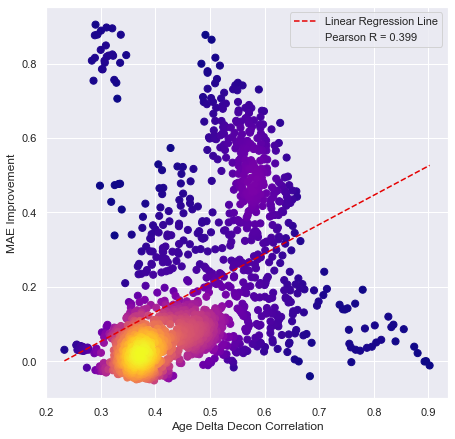

In [69]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.mae_improvements, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='MAE Improvement', title=None, set_scale=False, 
                   equality_line=False)

In [70]:
pr_df[pr_df.mae_improvements >= 0.8].sort_values('ensambled_mae')

,ensamble_name,corr_output_age_decon,corr_age_delta_decon,min_mae,ensambled_mae,mae_improvements
292,T2_lesions rsfmri_21,0.649273,0.290464,5.509517,4.604552,0.904965
293,T2_lesions rsfmri_22,0.661799,0.310507,5.509517,4.612203,0.897314
288,T2_lesions rsfmri_17,0.665647,0.321102,5.509517,4.614478,0.895039
278,T2_lesions rsfmri_7,0.653429,0.300571,5.509517,4.620605,0.888911
283,T2_lesions rsfmri_12,0.646010,0.294016,5.509517,4.631285,0.878232
271,T2_lesions rsfmri_0,0.680804,0.336732,5.509517,4.631645,0.877872
295,T2_lesions rsfmri_24,0.638993,0.289196,5.509517,4.633131,0.876385
276,T2_lesions rsfmri_5,0.650565,0.309406,5.509517,4.660462,0.849055
287,T2_lesions rsfmri_16,0.646829,0.299992,5.509517,4.672376,0.837140
280,T2_lesions rsfmri_9,0.662459,0.321207,5.509517,4.684588,0.824929


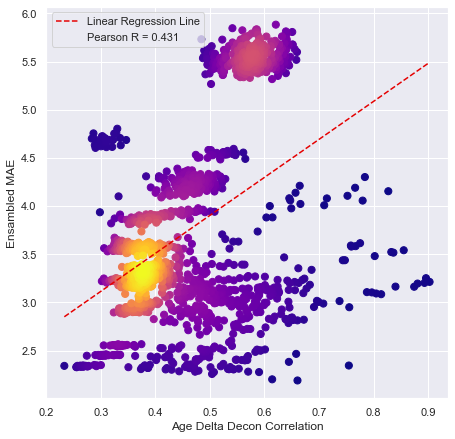

In [71]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.ensambled_mae, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='Ensambled MAE', title=None, set_scale=False, 
                   equality_line=False)

In [72]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.mae_improvements, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='MAE Improvement', title=None, set_scale=False, 
                   equality_line=False)pr_df[(pr_df.ensambled_mae <= 2.3) & (pr_df.mae_improvements > 0)].sort_values('ensambled_mae')

,ensamble_name,corr_output_age_decon,corr_age_delta_decon,min_mae,ensambled_mae,mae_improvements
3,T1_nonlinear T2_nonlinear,0.950530,0.660474,2.372138,2.189781,0.182357
58,T1_linear T2_nonlinear,0.940706,0.614109,2.372138,2.201603,0.170535
261,T2_nonlinear tbss_FA,0.909124,0.503920,2.372138,2.257036,0.115102
269,T2_nonlinear tbss_OD,0.904038,0.507411,2.372138,2.276296,0.095842
165,vbm T2_nonlinear,0.926969,0.590088,2.372138,2.276805,0.095333
253,T2_nonlinear tbss_ICVF_s,0.893347,0.472923,2.372138,2.280666,0.091472
262,T2_nonlinear tbss_ICVF,0.922429,0.570163,2.372138,2.281222,0.090916
252,T2_nonlinear tbss_FA_s,0.882704,0.443726,2.372138,2.284938,0.087200
268,T2_nonlinear tbss_MO,0.890685,0.479136,2.372138,2.291276,0.080862


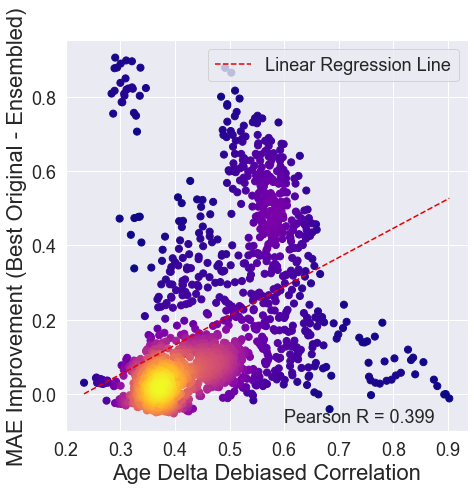

In [84]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.mae_improvements
xlabel='Age Delta Debiased Correlation'
ylabel='MAE Improvement (Best Original - Ensembled)'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = -0.075
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font)
plt.show()

fig.savefig('Female_linear_regression_ensembling_mae_improvement_vs_correlation.png', bbox_inches='tight', facecolor='white')


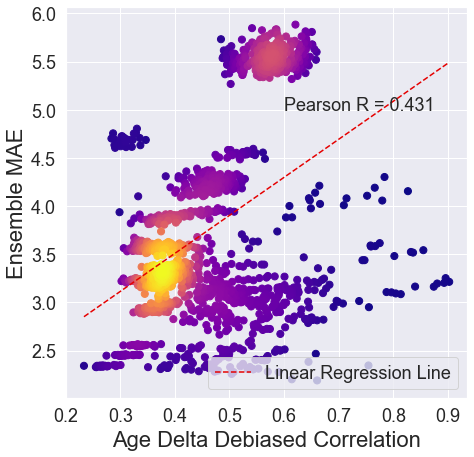

In [81]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.ensambled_mae
xlabel='Age Delta Debiased Correlation'
ylabel='Ensemble MAE'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = 5
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font)
plt.show()

fig.savefig('Female_linear_regression_ensembling_ensemble_mae_vs_correlation.png', bbox_inches='tight', facecolor='white')


## Attempt at Multiple Combinations with 3

In [63]:
# modalities = df.modality.to_list()
# ensamble_names = []
# min_maes = []
# ensambled_maes = []

# for subset in itertools.combinations(modalities, 3):
#     subset = list(subset)
#     ensamble_name = subset[0] + ' ' + subset[1] + ' ' + subset[2]
#     ensamble_names.append(ensamble_name)
    
#     min_mae = min(
#                     np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
#                     np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean(),
#                     np.abs(df.iloc[modalities.index(subset[2])].dataframe.age_delta_decon).mean()
#     )
#     min_maes.append(min_mae)
           
#     ensambled_mae = LinearRegression_wrap(df_train, df_test, modalities=subset, 
#                               number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)[3]
#     ensambled_maes.append(ensambled_mae)
    
    
    
# pr_df2 = pd.DataFrame.from_dict({
#     'ensamble_name': ensamble_names,
#     'min_mae': min_maes,
#     'ensambled_mae': ensambled_maes,
# })

# pr_df2['mae_improvements'] = pr_df2['min_mae'] - pr_df2['ensambled_mae']

In [64]:
# pr_df2

,ensamble_name,min_mae,ensambled_mae,mae_improvements
0,T1_nonlinear T1_linear jacobian,2.429445,2.344775,0.084669
1,T1_nonlinear T1_linear vbm,2.429445,2.321581,0.107864
2,T1_nonlinear T1_linear T2_nonlinear,2.372096,2.156821,0.215275
3,T1_nonlinear T1_linear T2_lesions,2.429445,2.341156,0.088289
4,T1_nonlinear T1_linear swi,2.429445,2.324874,0.104571
...,...,...,...,...
29255,tbss_L2 tbss_MO tbss_OD,3.165990,2.900903,0.265087
29256,tbss_L3 tbss_MD tbss_MO,3.252166,2.976753,0.275414
29257,tbss_L3 tbss_MD tbss_OD,3.165990,2.993077,0.172913
29258,tbss_L3 tbss_MO tbss_OD,3.165990,2.901443,0.264547


In [82]:
# pr_df2.sort_values('mae_improvements', ascending=False)

,ensamble_name,min_mae,ensambled_mae,mae_improvements
7913,T2_lesions rsfmri_17 rsfmri_24,5.509571,4.387680,1.121891
7881,T2_lesions rsfmri_16 rsfmri_24,5.509571,4.393902,1.115669
8031,T2_lesions rsfmri_21 rsfmri_24,5.509571,4.404187,1.105384
7463,T2_lesions rsfmri_5 rsfmri_24,5.509571,4.421287,1.088284
23372,rsfmri_16 rsfmri_20 rsfmri_24,6.245858,5.157764,1.088094
...,...,...,...,...
12339,rsfmri_2 rsfmri_11 tbss_MD,3.252166,3.296014,-0.043847
11137,rsfmri_1 rsfmri_8 tbss_ISOVF,3.143365,3.187244,-0.043879
12636,rsfmri_2 rsfmri_20 tbss_MD,3.252166,3.296648,-0.044482
10967,rsfmri_1 rsfmri_4 tbss_ISOVF,3.143365,3.188356,-0.044991


In [65]:
# print(len(pr_df2))
# pr_df2[(pr_df2.ensambled_mae <= 2.275) & (pr_df2.mae_improvements > 0)].sort_values('ensambled_mae')

29260


,ensamble_name,min_mae,ensambled_mae,mae_improvements
205,T1_nonlinear T2_nonlinear tbss_FA,2.372096,2.155988,0.216108
2,T1_nonlinear T1_linear T2_nonlinear,2.372096,2.156821,0.215275
196,T1_nonlinear T2_nonlinear tbss_FA_s,2.372096,2.163828,0.208268
204,T1_nonlinear T2_nonlinear tbss_OD_s,2.372096,2.165537,0.206560
206,T1_nonlinear T2_nonlinear tbss_ICVF,2.372096,2.165584,0.206513
...,...,...,...,...
6598,T2_nonlinear rsfmri_15 tbss_OD,2.372096,2.274488,0.097608
6663,T2_nonlinear rsfmri_17 tbss_OD,2.372096,2.274629,0.097467
6493,T2_nonlinear rsfmri_12 tbss_OD,2.372096,2.274654,0.097442
4461,vbm T2_nonlinear rsfmri_3,2.372096,2.274680,0.097416


In [74]:
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2573...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2573...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2573...


# 5. Fit Model to highly correlated groups (Notebook 4)

In [73]:
smri_mod = modalities[:7]
rsfmri_mod = modalities[7:32]
tfmri_mod = modalities[32:38]
dmri_mod = modalities[38:]
tbss_s_mod = dmri_mod[1:10]
tbss_mod = dmri_mod[10:]

rsfmri_jac_mod = rsfmri_mod + ['jacobian']
tfmri_jac_mod = tfmri_mod + ['jacobian']

fmri_mod = rsfmri_mod + tfmri_mod
fmri_jac_mod = rsfmri_mod + tfmri_mod + ['jacobian']

tbss_s_mod_tracts = dmri_mod[1:10] + ['tracts']
tbss_mod_tract = dmri_mod[10:] + ['tracts']

mod_list = [smri_mod, rsfmri_mod, tfmri_mod, dmri_mod, tbss_s_mod, tbss_mod, rsfmri_jac_mod, tfmri_jac_mod, 
             fmri_mod, fmri_jac_mod, tbss_s_mod_tracts, tbss_mod_tract]
mod_names = ['smri_mod', 'rsfmri_mod', 'tfmri_mod', 'dmri_mod', 'tbss_s_mod', 'tbss_mod', 'rsfmri_jac_mod', 
             'tfmri_jac_mod', 'fmri_mod', 'fmri_jac_mod', 'tbss_s_mod_tracts', 'tbss_mod_tract']

modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

def ensamble_sub_modality_groups(sub_modality_group, mae_df, df, df_train, df_test, sub_modality_name):

    ordered_modalities = mae_df.modality.to_list()
    ordered_modalities = [modality for modality in ordered_modalities if modality in sub_modality_group]
    print(ordered_modalities)

    maes_list = []

    for i in range(2, len(ordered_modalities)+1):
        modalities = ordered_modalities[:i]
        x = LinearRegression_wrap(df_train, df_test, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
                
        ensambled_mae = x[3]
        maes_list.append(ensambled_mae)
        number_of_modalitiest.append(i)
        
    plt.figure(figsize=(12.8, 4.8))
    plt.subplot(121)
    plt.plot(maes_list)
    plt.title(sub_modality_name)
    plt.plot([],[],' ',label='MIN MAE=' + str(min(maes_list)))
    plt.plot([],[],' ',label='MIN LOC=' + str(1 + np.argmin(np.array(maes_list))))
    plt.legend()
    plt.xlabel('No of Modalitities Ensambled with MAE Rank')
    plt.ylabel('Ensambled MAE')
    plt.show()
    
    print('-------')


['T2_nonlinear', 'T1_nonlinear', 'T1_linear', 'vbm', 'swi', 'jacobian', 'T2_lesions']


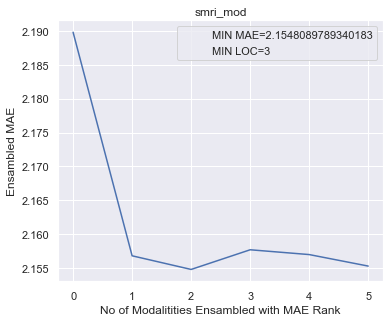

-------
['rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18', 'rsfmri_21', 'rsfmri_7', 'rsfmri_1', 'rsfmri_9', 'rsfmri_3', 'rsfmri_13', 'rsfmri_12', 'rsfmri_15', 'rsfmri_2', 'rsfmri_16', 'rsfmri_5', 'rsfmri_23', 'rsfmri_4', 'rsfmri_24', 'rsfmri_10', 'rsfmri_20', 'rsfmri_14', 'rsfmri_8', 'rsfmri_6', 'rsfmri_19']


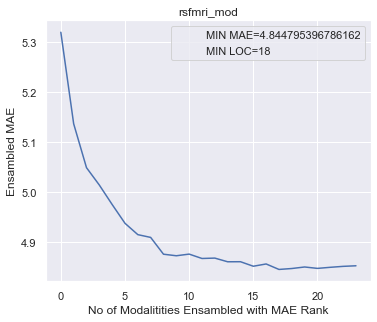

-------
['tfmri_1', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5', 'tfmri_2', 'tfmri_5']


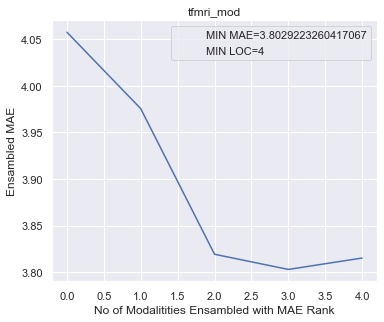

-------
['tbss_ICVF', 'tbss_FA', 'tbss_ISOVF', 'tbss_OD', 'tbss_L2', 'tbss_L1', 'tbss_MD', 'tbss_L3', 'tbss_ICVF_s', 'tbss_MO', 'tbss_FA_s', 'tbss_L1_s', 'tracts', 'tbss_L2_s', 'tbss_MD_s', 'tbss_L3_s', 'tbss_OD_s', 'tbss_ISOVF_s', 'tbss_MO_s']


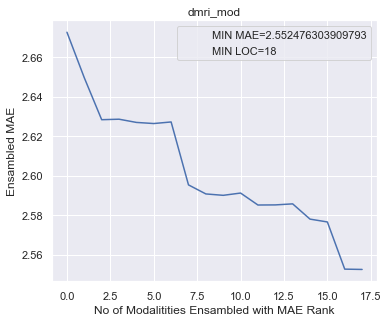

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_L1_s', 'tbss_L2_s', 'tbss_MD_s', 'tbss_L3_s', 'tbss_OD_s', 'tbss_ISOVF_s', 'tbss_MO_s']


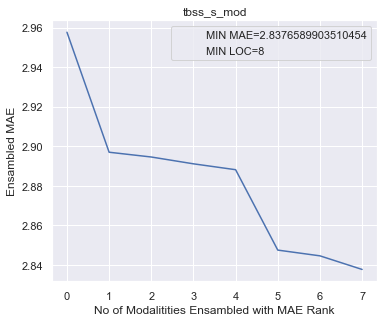

-------
['tbss_ICVF', 'tbss_FA', 'tbss_ISOVF', 'tbss_OD', 'tbss_L2', 'tbss_L1', 'tbss_MD', 'tbss_L3', 'tbss_MO']


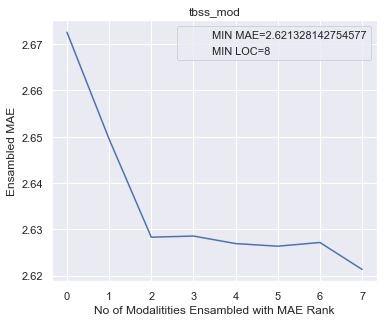

-------
['jacobian', 'rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18', 'rsfmri_21', 'rsfmri_7', 'rsfmri_1', 'rsfmri_9', 'rsfmri_3', 'rsfmri_13', 'rsfmri_12', 'rsfmri_15', 'rsfmri_2', 'rsfmri_16', 'rsfmri_5', 'rsfmri_23', 'rsfmri_4', 'rsfmri_24', 'rsfmri_10', 'rsfmri_20', 'rsfmri_14', 'rsfmri_8', 'rsfmri_6', 'rsfmri_19']


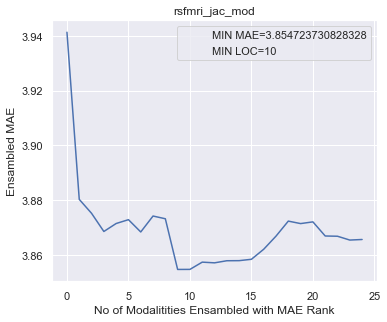

-------
['jacobian', 'tfmri_1', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5', 'tfmri_2', 'tfmri_5']


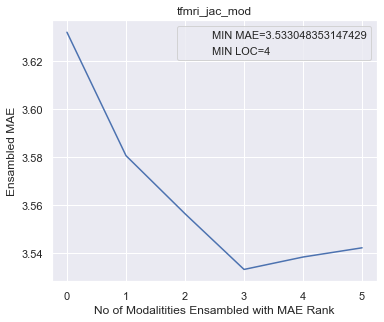

-------
['tfmri_1', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5', 'tfmri_2', 'tfmri_5', 'rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18', 'rsfmri_21', 'rsfmri_7', 'rsfmri_1', 'rsfmri_9', 'rsfmri_3', 'rsfmri_13', 'rsfmri_12', 'rsfmri_15', 'rsfmri_2', 'rsfmri_16', 'rsfmri_5', 'rsfmri_23', 'rsfmri_4', 'rsfmri_24', 'rsfmri_10', 'rsfmri_20', 'rsfmri_14', 'rsfmri_8', 'rsfmri_6', 'rsfmri_19']


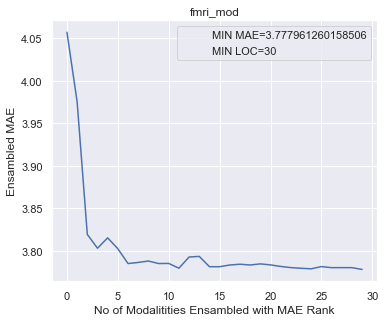

-------
['jacobian', 'tfmri_1', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5', 'tfmri_2', 'tfmri_5', 'rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18', 'rsfmri_21', 'rsfmri_7', 'rsfmri_1', 'rsfmri_9', 'rsfmri_3', 'rsfmri_13', 'rsfmri_12', 'rsfmri_15', 'rsfmri_2', 'rsfmri_16', 'rsfmri_5', 'rsfmri_23', 'rsfmri_4', 'rsfmri_24', 'rsfmri_10', 'rsfmri_20', 'rsfmri_14', 'rsfmri_8', 'rsfmri_6', 'rsfmri_19']


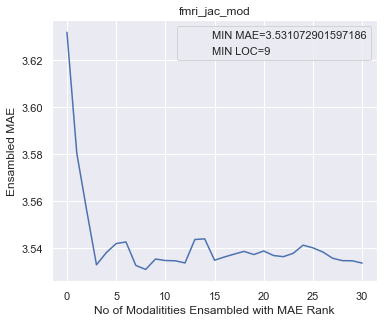

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_L1_s', 'tracts', 'tbss_L2_s', 'tbss_MD_s', 'tbss_L3_s', 'tbss_OD_s', 'tbss_ISOVF_s', 'tbss_MO_s']


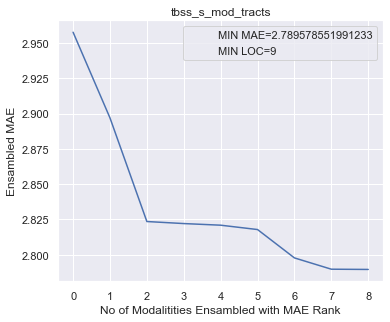

-------
['tbss_ICVF', 'tbss_FA', 'tbss_ISOVF', 'tbss_OD', 'tbss_L2', 'tbss_L1', 'tbss_MD', 'tbss_L3', 'tbss_MO', 'tracts']


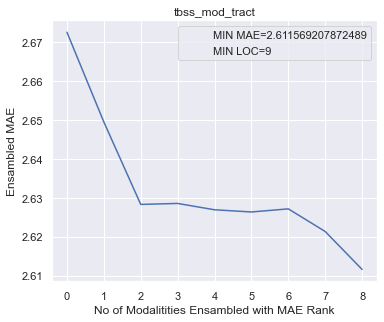

-------


In [67]:
for idx, sub_mod in enumerate(mod_list):
    ensamble_sub_modality_groups(sub_modality_group=sub_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=mod_names[idx])


In [68]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=smri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

,modality,min_single_mae,ensambled_mae,mae_improvement
48,jacobian T2_lesions swi,3.626171,3.218607,0.407565
11,jacobian T2_lesions,4.010293,3.671985,0.338307
12,jacobian swi,3.626171,3.294016,0.332155
94,T1_nonlinear T1_linear vbm T2_nonlinear T2_les...,2.372096,2.153259,0.218837
109,T1_nonlinear T1_linear jacobian vbm T2_nonline...,2.372096,2.154119,0.217977


In [69]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=tfmri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

,modality,min_single_mae,ensambled_mae,mae_improvement
53,tfmri_1 tfmri_2 tfmri_c_1 tfmri_c_2 tfmri_c_5,4.249898,3.802922,0.446976
39,tfmri_1 tfmri_2 tfmri_c_1 tfmri_c_5,4.249898,3.810051,0.439847
56,tfmri_1 tfmri_2 tfmri_5 tfmri_c_1 tfmri_c_2 tf...,4.249898,3.815155,0.434742
44,tfmri_1 tfmri_c_1 tfmri_c_2 tfmri_c_5,4.249898,3.819203,0.430695
40,tfmri_1 tfmri_2 tfmri_c_2 tfmri_c_5,4.249898,3.821609,0.428288


MAE= 3.778101477283668
PR= 0.7569737511300197
MAE Decon= 5.013480524633552
PR Decon= 0.7569737511300197


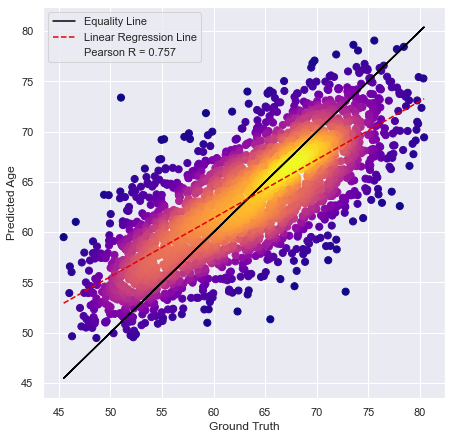

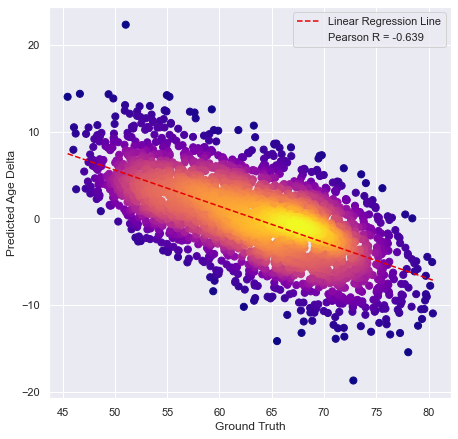

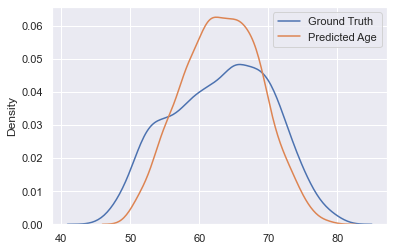

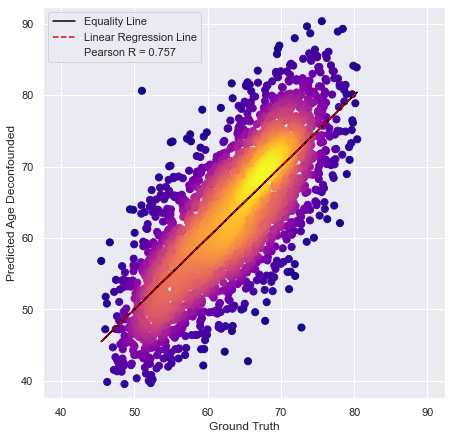

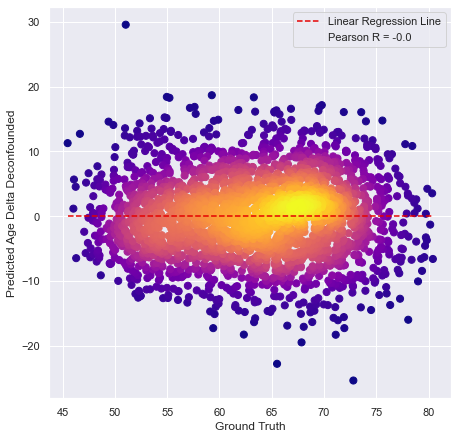

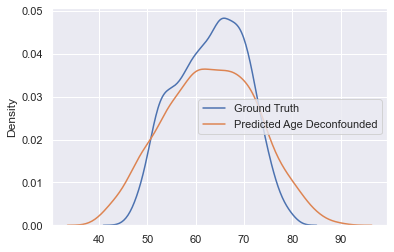

In [70]:
tmp_mod= ['rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18']
# tmp_mod = ['rsfmri_0', 'rsfmri_22', 'rsfmri_11']
_ = LinearRegression_wrap(df_train, df_test, modalities = tmp_mod, 
                      number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

['rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18', 'rsfmri_21', 'rsfmri_7', 'rsfmri_1', 'rsfmri_9', 'rsfmri_3', 'rsfmri_13', 'rsfmri_12', 'rsfmri_15', 'rsfmri_2', 'rsfmri_16', 'rsfmri_5', 'rsfmri_23', 'rsfmri_4', 'rsfmri_24', 'rsfmri_10', 'rsfmri_20', 'rsfmri_14', 'rsfmri_8', 'rsfmri_6', 'rsfmri_19']


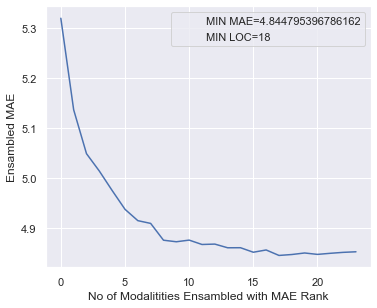

-------


In [71]:
ensamble_sub_modality_groups(sub_modality_group=rsfmri_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=None)

In [72]:
_ = LinearRegression_wrap(df_train, df_test, modalities = tmp_mod, 
                      number_of_modalities=None, show_plots=False, verbose=True)

MAE= 3.778101477283668
PR= 0.7569737511300197
